In [1]:
import numpy as np
import pandas as pd
import cv2
import functools

import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA

from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier

from sklearn.model_selection import train_test_split

from model_testing import ModelSelection
from plotting import show_distribution
from plot_val import calc_roc_curve, plot_roc_curve, plot_confusion_matrix

from apply_processing import apply, resize_images, function_hsv, function_gray
from apply_processing import function_label, blur_images, adjust_contrast_images, rotated_labels
from apply_processing import filter_images, edge_images, contour_images, rotate_images

In [2]:
df = pd.read_csv("Dataset\\images_mushrooms.csv")

df.head()

,Image,Label
0,Dataset\Mushrooms\Agaricus\009_mrv34Sn4WiQ.jpg,Agaricus
1,Dataset\Mushrooms\Agaricus\010_Rk1D3EG856g.jpg,Agaricus
2,Dataset\Mushrooms\Agaricus\017_QHGfbEiWvq8.jpg,Agaricus
3,Dataset\Mushrooms\Agaricus\020_vZJfrjIwmqU.jpg,Agaricus
4,Dataset\Mushrooms\Agaricus\030_-i6kYqDvBQo.jpg,Agaricus


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 900 entries, 0 to 899
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Image   900 non-null    object
 1   Label   900 non-null    object
dtypes: object(2)
memory usage: 14.2+ KB


In [4]:
df['Label'].value_counts()

Entoloma       100
Agaricus       100
Lactarius      100
Amanita        100
Suillus        100
Hygrocybe      100
Russula        100
Boletus        100
Cortinarius    100
Name: Label, dtype: int64

# Processing the images

## No Augmentation

In [5]:
# Fixed contrast, brightness, sharpness

def processing_noAug(df):
    images = df['Image']
    labels = df["Label"]
    
    size = (150, 150)
    
    mod_images = function_hsv(images)
    mod_images = resize_images(mod_images, size)
    mod_images = filter_images(mod_images)
    mod_images = adjust_contrast_images(mod_images, contrast=1.75, brightness=50)
    mod_images = blur_images(mod_images)
    
    return mod_images, labels

images_noAug, labels_noAug = processing_noAug(df)

## Augmentation function

In [6]:
# With Contour + Fixed contrast, brightness, sharpness

def processing_contour(df):
    images = df['Image']
    labels = df['Label']
    
    size = (150, 150)
    contrast = 1.75
    brightness = 50
    
    images_hsv = function_hsv(images)
    images_hsv = resize_images(images_hsv, size)
    images_hsv = filter_images(images_hsv)
    images_hsv = adjust_contrast_images(images_hsv, contrast=contrast, brightness=brightness)
    images_hsv = blur_images(images_hsv)
    
    images_gray = function_gray(images)
    images_gray = resize_images(images_gray, size)
    images_gray = filter_images(images_gray)
    images_gray = adjust_contrast_images(images_gray, contrast=contrast, brightness=brightness)
    images_gray = blur_images(images_gray)
    
    edged_images = edge_images(images_gray)
    
    images_contour = contour_images(edged_images, images_hsv)
    
    return list(images_contour)

In [7]:
# Random Contrast, Brightness, Sharpness

def processing_random(df):
    images = df['Image']
    labels = df['Label']
    
    size = (150, 150)
    contrast = np.random.randint(1, 5)
    brightness = np.random.randint(-100, 100)
    
    images_hsv = function_hsv(images)
    images_hsv = resize_images(images_hsv, size)
    images_hsv = filter_images(images_hsv)
    images_hsv = adjust_contrast_images(images_hsv, contrast=contrast, brightness=brightness)
    images_hsv = blur_images(images_hsv)
    
    return list(images_hsv)

In [8]:
# Fixed contrast, brightness, sharpness

def processing_fixed(df):
    images = df['Image']
    labels = df['Label']
    
    size = (150, 150)
    contrast = 1.75
    brightness = 50
    
    images_hsv = function_hsv(images)
    images_hsv = resize_images(images_hsv, size)
    images_hsv = filter_images(images_hsv)
    images_hsv = adjust_contrast_images(images_hsv, contrast=contrast, brightness=brightness)
    images_hsv = blur_images(images_hsv)
    
    return list(images_hsv)

In [9]:
# Rotated and flipped images

def processing_rotated(df):
    images = df['Image']
    labels = df['Label']
    
    size = (150, 150)
    contrast = 1.75
    brightness = 50
    
    images_hsv = function_hsv(images)
    images_hsv = resize_images(images_hsv, size)
    images_hsv = filter_images(images_hsv)
    images_hsv = adjust_contrast_images(images_hsv, contrast=contrast, brightness=brightness)
    images_hsv = blur_images(images_hsv)
    images_hsv = rotate_images(images_hsv)
    
    return list(images_hsv)

In [10]:
functions = [processing_contour, processing_random, processing_fixed]
labels = [function_label, function_label, function_label]

images_aug, labels_aug = apply(functions, labels, df)

# Images info

In [11]:
print(f"Length of images no augmentation {len(images_noAug)}")
print(f"Length of images with augmentation {len(images_aug)}")

Length of images no augmentation 900
Length of images with augmentation 2700


## Images info no augmentation

In [12]:
# show_distribution(images_noAug)

## Images info augmentation

In [13]:
# show_distribution(images_aug)

# Modelling with no augmentation

## Reduction with PCA

In [14]:
scaler = MinMaxScaler()
le = LabelEncoder()

pca = PCA(n_components=100)

In [15]:
images = [np.ravel(image) for image in images_noAug]

images_scaled = scaler.fit_transform(images)
labels_encoded = le.fit_transform(df["Label"])

In [16]:
images_pca = pca.fit_transform(images_scaled, labels_encoded)

images_pca_df = pd.DataFrame(data=images_pca)
images_pca_df["Label"] = le.inverse_transform(labels_encoded)

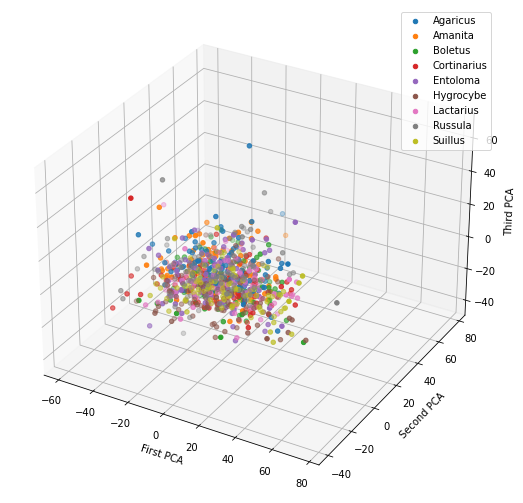

In [17]:
fig = plt.figure(figsize=(15,9))

ax = fig.add_subplot(projection='3d')

for label in images_pca_df["Label"].unique():
    first_pca = images_pca_df[images_pca_df["Label"] == label][0]
    second_pca = images_pca_df[images_pca_df["Label"] == label][1]
    third_pca = images_pca_df[images_pca_df["Label"] == label][2]
    
    ax.scatter(first_pca, second_pca, third_pca, label=label)
    
ax.legend()

ax.set_xlabel("First PCA")
ax.set_ylabel("Second PCA")
ax.set_zlabel("Third PCA")

plt.show()

## Modelling

In [18]:
X = images_pca_df.drop(columns=["Label"])
y = pd.Series(le.fit_transform(images_pca_df["Label"]))

### Using train_test_split

In [19]:
selection = ModelSelection(X, y, [RandomForestClassifier(), DecisionTreeClassifier(), MLPClassifier(), SVC()])

In [20]:
selection.use_train_test_split()

Model info
--------------------
Model name : RandomForestClassifier
Model name : DecisionTreeClassifier
Model name : MLPClassifier
Model name : SVC

Training models
--------------------
Done Training RandomForestClassifier in time:0.6236617565155029
Done Training DecisionTreeClassifier in time:0.6825635433197021


C:\Users\Bina Umat\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Done Training MLPClassifier in time:2.200132131576538
Done Training SVC in time:2.3801488876342773
--------------------
Done Training models in time : 2.3801488876342773


The Scores :

Train RandomForestClassifier score : 1.0
Train DecisionTreeClassifier score : 1.0
Train MLPClassifier score : 0.9983416252072969
Train SVC score : 0.8706467661691543
----------
Test RandomForestClassifier score : 0.21885521885521886
Test DecisionTreeClassifier score : 0.18518518518518517
Test MLPClassifier score : 0.2255892255892256
Test SVC score : 0.3164983164983165
----------
Bias RandomForestClassifier score : 0.7811447811447811
Bias DecisionTreeClassifier score : 0.8148148148148149
Bias MLPClassifier score : 0.7727523996180713
Bias SVC score : 0.5541484496708378
----------


### Using StratifiedKFold

In [21]:
selection = ModelSelection(X, y, [RandomForestClassifier(), DecisionTreeClassifier(), MLPClassifier(), SVC()])

In [22]:
selection.use_stratifiedkfold()

Fold 1
----------

Training models

--------------------
Done Training RandomForestClassifier in time:0.7068047523498535

The Scores :

Train RandomForestClassifier score : 1.0
Test RandomForestClassifier score : 0.2833333333333333
Bias RandomForestClassifier score : 0.7166666666666667

--------------------
Done Training DecisionTreeClassifier in time:0.7758662700653076

The Scores :

Train DecisionTreeClassifier score : 1.0
Test DecisionTreeClassifier score : 0.20555555555555555
Bias DecisionTreeClassifier score : 0.7944444444444445


C:\Users\Bina Umat\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(



--------------------
Done Training MLPClassifier in time:2.4963812828063965

The Scores :

Train MLPClassifier score : 1.0
Test MLPClassifier score : 0.20555555555555555
Bias MLPClassifier score : 0.7944444444444445

--------------------
Done Training SVC in time:2.7594707012176514

The Scores :

Train SVC score : 0.8569444444444444
Test SVC score : 0.3388888888888889
Bias SVC score : 0.5180555555555555
--------------------
Done Training models in time : 2.7594707012176514

Fold 2
----------

Training models

--------------------
Done Training RandomForestClassifier in time:0.6985750198364258

The Scores :

Train RandomForestClassifier score : 1.0
Test RandomForestClassifier score : 0.22777777777777777
Bias RandomForestClassifier score : 0.7722222222222223

--------------------
Done Training DecisionTreeClassifier in time:0.761793851852417

The Scores :

Train DecisionTreeClassifier score : 1.0
Test DecisionTreeClassifier score : 0.14444444444444443
Bias DecisionTreeClassifier score :

C:\Users\Bina Umat\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(



--------------------
Done Training MLPClassifier in time:2.4154436588287354

The Scores :

Train MLPClassifier score : 1.0
Test MLPClassifier score : 0.20555555555555555
Bias MLPClassifier score : 0.7944444444444445

--------------------
Done Training SVC in time:2.668728828430176

The Scores :

Train SVC score : 0.8527777777777777
Test SVC score : 0.32222222222222224
Bias SVC score : 0.5305555555555554
--------------------
Done Training models in time : 2.6697282791137695

Fold 3
----------

Training models

--------------------
Done Training RandomForestClassifier in time:0.7095036506652832

The Scores :

Train RandomForestClassifier score : 1.0
Test RandomForestClassifier score : 0.24444444444444444
Bias RandomForestClassifier score : 0.7555555555555555

--------------------
Done Training DecisionTreeClassifier in time:0.7625072002410889

The Scores :

Train DecisionTreeClassifier score : 1.0
Test DecisionTreeClassifier score : 0.17777777777777778
Bias DecisionTreeClassifier score 

C:\Users\Bina Umat\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(



--------------------
Done Training MLPClassifier in time:2.465740203857422

The Scores :

Train MLPClassifier score : 1.0
Test MLPClassifier score : 0.21666666666666667
Bias MLPClassifier score : 0.7833333333333333

--------------------
Done Training SVC in time:2.7065489292144775

The Scores :

Train SVC score : 0.8472222222222222
Test SVC score : 0.32222222222222224
Bias SVC score : 0.5249999999999999
--------------------
Done Training models in time : 2.7065489292144775

Fold 4
----------

Training models

--------------------
Done Training RandomForestClassifier in time:0.6851048469543457

The Scores :

Train RandomForestClassifier score : 1.0
Test RandomForestClassifier score : 0.2611111111111111
Bias RandomForestClassifier score : 0.7388888888888889

--------------------
Done Training DecisionTreeClassifier in time:0.7542023658752441

The Scores :

Train DecisionTreeClassifier score : 1.0
Test DecisionTreeClassifier score : 0.16666666666666666
Bias DecisionTreeClassifier score :

C:\Users\Bina Umat\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(



--------------------
Done Training MLPClassifier in time:2.4259979724884033

The Scores :

Train MLPClassifier score : 1.0
Test MLPClassifier score : 0.24444444444444444
Bias MLPClassifier score : 0.7555555555555555

--------------------
Done Training SVC in time:2.6749343872070312

The Scores :

Train SVC score : 0.8458333333333333
Test SVC score : 0.3111111111111111
Bias SVC score : 0.5347222222222222
--------------------
Done Training models in time : 2.6749343872070312

Fold 5
----------

Training models

--------------------
Done Training RandomForestClassifier in time:0.6915326118469238

The Scores :

Train RandomForestClassifier score : 1.0
Test RandomForestClassifier score : 0.25
Bias RandomForestClassifier score : 0.75

--------------------
Done Training DecisionTreeClassifier in time:0.7524621486663818

The Scores :

Train DecisionTreeClassifier score : 1.0
Test DecisionTreeClassifier score : 0.17777777777777778
Bias DecisionTreeClassifier score : 0.8222222222222222


C:\Users\Bina Umat\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(



--------------------
Done Training MLPClassifier in time:2.432330846786499

The Scores :

Train MLPClassifier score : 1.0
Test MLPClassifier score : 0.22777777777777777
Bias MLPClassifier score : 0.7722222222222223

--------------------
Done Training SVC in time:2.6762170791625977

The Scores :

Train SVC score : 0.8458333333333333
Test SVC score : 0.2833333333333333
Bias SVC score : 0.5625
--------------------
Done Training models in time : 2.6762170791625977


The Mean Scores :

Train mean RandomForestClassifier score : 1.0
Train mean DecisionTreeClassifier score : 1.0
Train mean MLPClassifier score : 1.0
Train mean SVC score : 0.8458333333333333
----------
Test mean RandomForestClassifier score : 0.25
Test mean DecisionTreeClassifier score : 0.17777777777777778
Test mean MLPClassifier score : 0.22777777777777777
Test mean SVC score : 0.2833333333333333
----------
Bias mean RandomForestClassifier score : 0.75
Bias mean DecisionTreeClassifier score : 0.8222222222222222
Bias mean MLPC

## Evaluation

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [24]:
svm = SVC(probability=True)
dtc = DecisionTreeClassifier()
mlpc = MLPClassifier()
rfc = RandomForestClassifier()

In [25]:
svm.fit(X_train, y_train)
dtc.fit(X_train, y_train)
mlpc.fit(X_train, y_train)
rfc.fit(X_train, y_train)

C:\Users\Bina Umat\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


RandomForestClassifier()

### ROC Curve and AUC

In [26]:
svm_proba = svm.predict_proba(X_test)
dtc_proba = dtc.predict_proba(X_test)
mlpc_proba = mlpc.predict_proba(X_test)
rfc_proba = rfc.predict_proba(X_test)

In [27]:
fprs_svm, tprs_svm, aucs_svm = calc_roc_curve(y_test, svm_proba)
fprs_dtc, tprs_dtc, aucs_dtc = calc_roc_curve(y_test, dtc_proba)
fprs_mlpc, tprs_mlpc, aucs_mlpc = calc_roc_curve(y_test, mlpc_proba)
fprs_rfc, tprs_rfc, aucs_rfc = calc_roc_curve(y_test, rfc_proba)

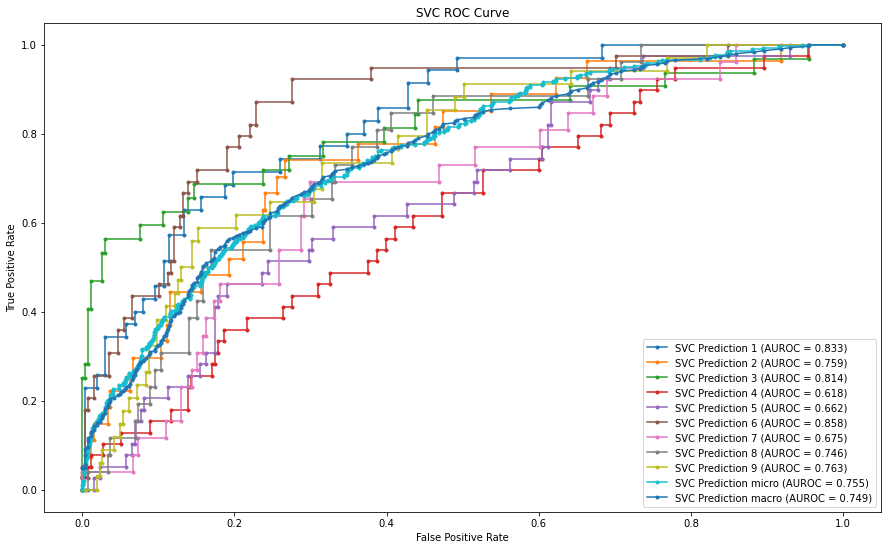

In [28]:
fig = plt.figure(figsize=(15, 9))

plot_roc_curve(fprs_svm, tprs_svm, aucs_svm, "SVC")

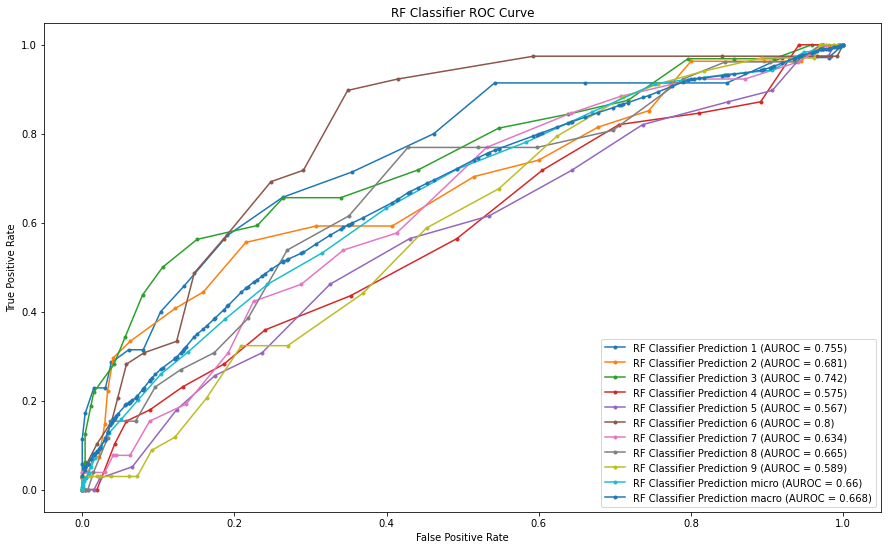

In [29]:
fig = plt.figure(figsize=(15, 9))

plot_roc_curve(fprs_rfc, tprs_rfc, aucs_rfc, "RF Classifier")

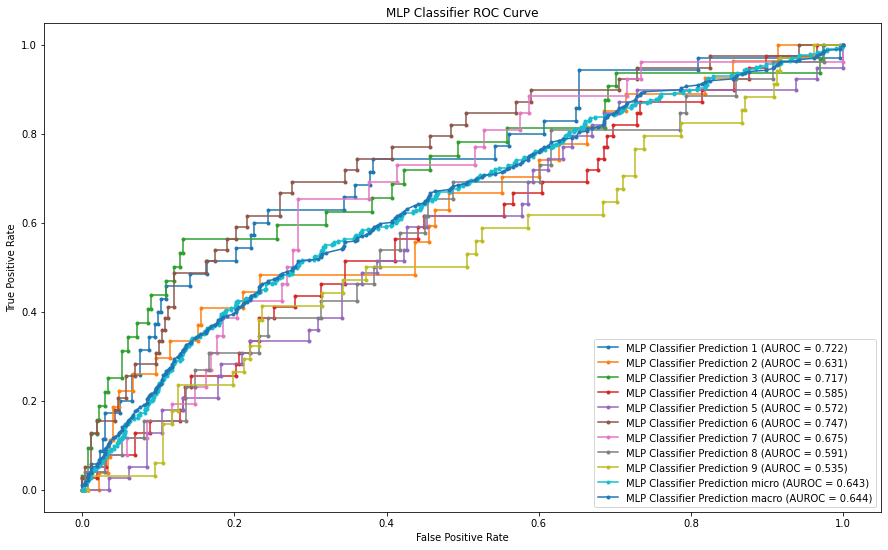

In [30]:
fig = plt.figure(figsize=(15, 9))

plot_roc_curve(fprs_mlpc, tprs_mlpc, aucs_mlpc, "MLP Classifier")

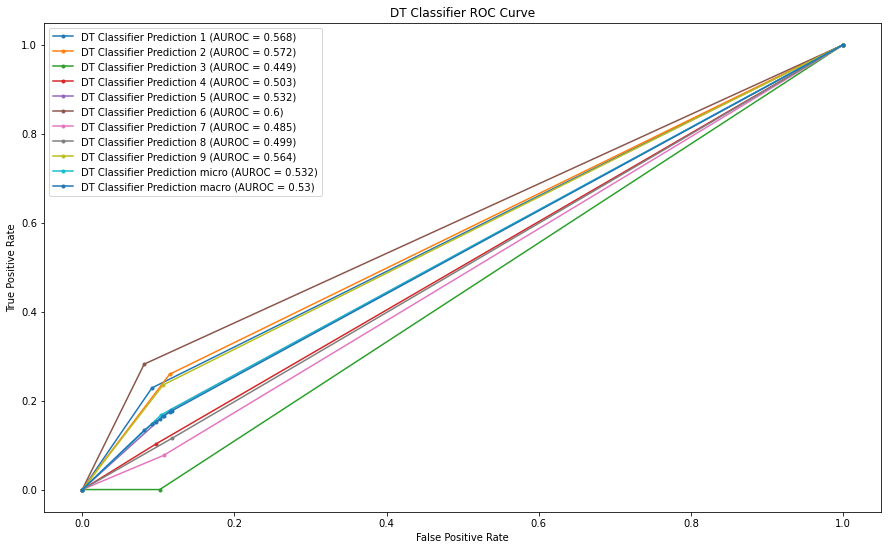

In [31]:
fig = plt.figure(figsize=(15, 9))

plot_roc_curve(fprs_dtc, tprs_dtc, aucs_dtc, "DT Classifier")

### Confusion Matrix

In [32]:
svm_pred = svm.predict(X_test)
dtc_pred = dtc.predict(X_test)
mlpc_pred = mlpc.predict(X_test)
rfc_pred = rfc.predict(X_test)

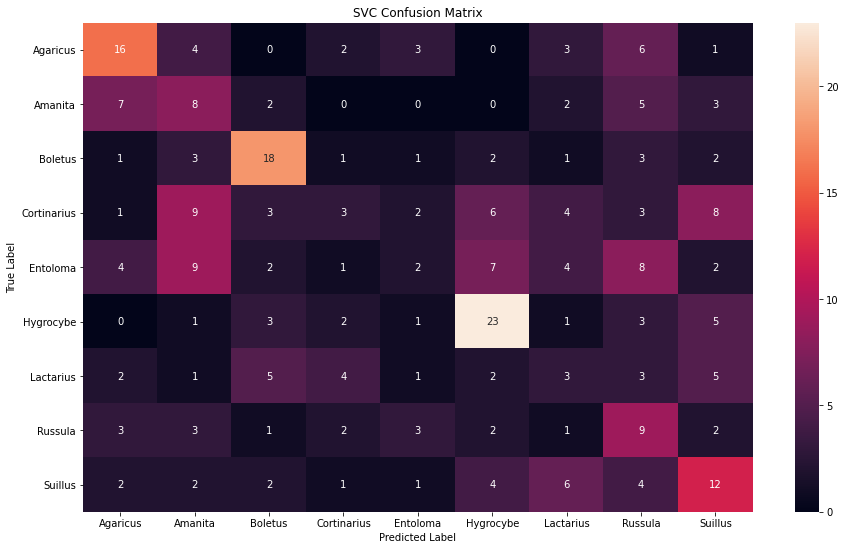

In [33]:
fig = plt.figure(figsize=(15, 9))

plot_confusion_matrix(df["Label"], y_test, svm_pred, 'SVC')

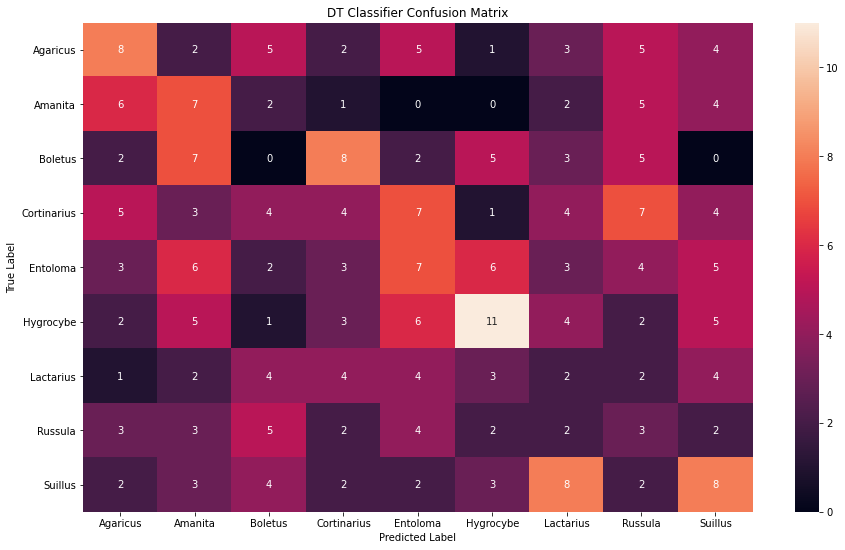

In [34]:
fig = plt.figure(figsize=(15, 9))

plot_confusion_matrix(df["Label"], y_test, dtc_pred, 'DT Classifier')

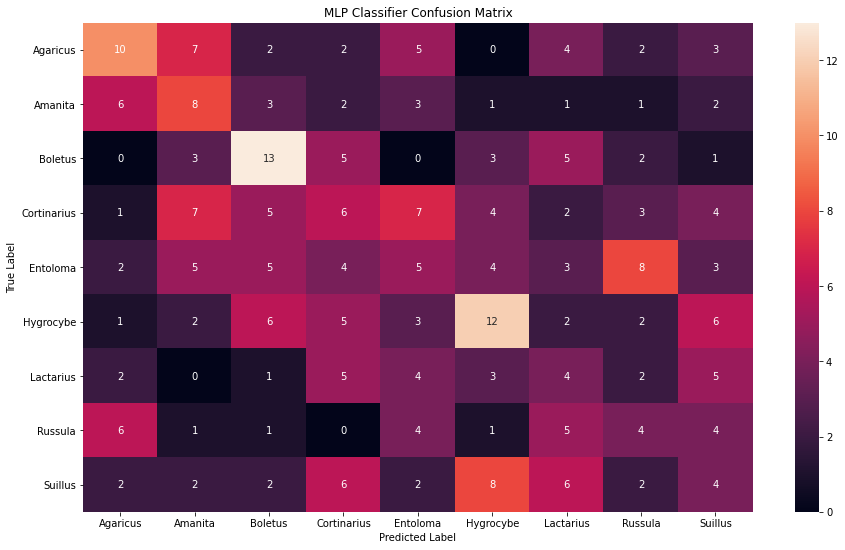

In [35]:
fig = plt.figure(figsize=(15, 9))

plot_confusion_matrix(df["Label"], y_test, mlpc_pred, 'MLP Classifier')

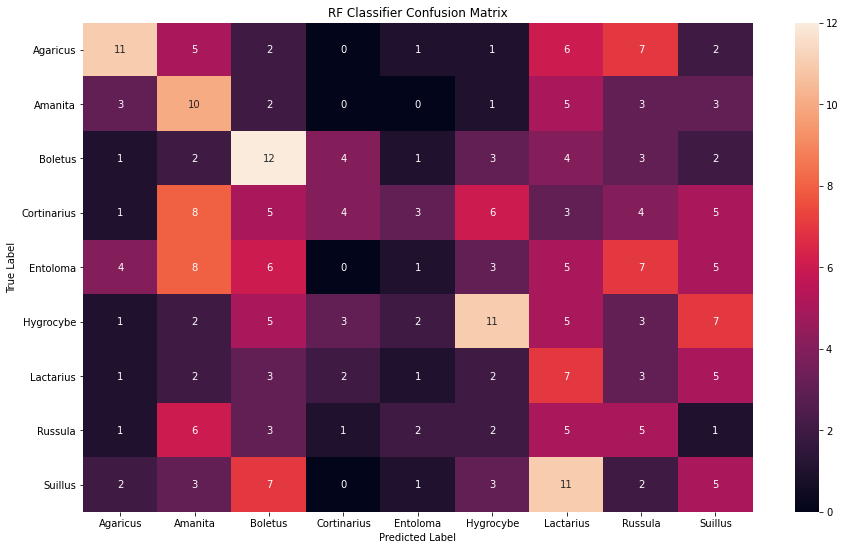

In [36]:
fig = plt.figure(figsize=(15, 9))

plot_confusion_matrix(df["Label"], y_test, rfc_pred, 'RF Classifier')

# Modelling with augmentation

## Reduction with PCA

In [37]:
scaler = MinMaxScaler()
le = LabelEncoder()

pca = PCA(n_components=100)

In [38]:
images = [np.ravel(image) for image in images_aug]

images_scaled = scaler.fit_transform(images)
labels_encoded = le.fit_transform(labels_aug)

In [39]:
images_pca = pca.fit_transform(images_scaled, labels_encoded)

images_pca_df = pd.DataFrame(data=images_pca)
images_pca_df["Label"] = le.inverse_transform(labels_encoded)

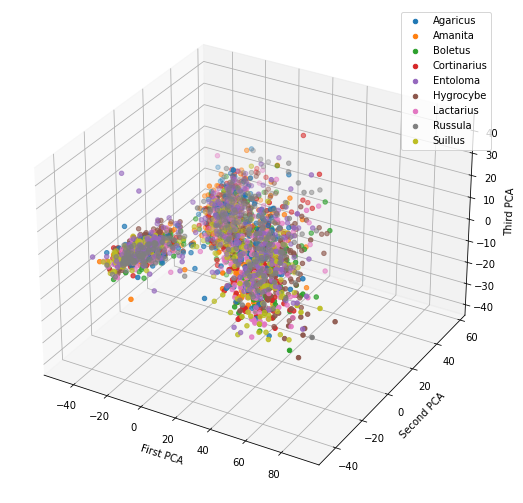

In [40]:
fig = plt.figure(figsize=(15,9))

ax = fig.add_subplot(projection='3d')

for label in images_pca_df["Label"].unique():
    first_pca = images_pca_df[images_pca_df["Label"] == label][0]
    second_pca = images_pca_df[images_pca_df["Label"] == label][1]
    third_pca = images_pca_df[images_pca_df["Label"] == label][2]
    
    ax.scatter(first_pca, second_pca, third_pca, label=label)
    
ax.legend()

ax.set_xlabel("First PCA")
ax.set_ylabel("Second PCA")
ax.set_zlabel("Third PCA")

plt.show()

## Modelling

In [41]:
X = images_pca_df.drop(columns=["Label"])
y = pd.Series(le.fit_transform(images_pca_df["Label"]))

### Using train_test_split

In [42]:
selection = ModelSelection(X, y, [RandomForestClassifier(), DecisionTreeClassifier(), MLPClassifier(), SVC()])

In [43]:
selection.use_train_test_split()

Model info
--------------------
Model name : RandomForestClassifier
Model name : DecisionTreeClassifier
Model name : MLPClassifier
Model name : SVC

Training models
--------------------
Done Training RandomForestClassifier in time:2.219958782196045
Done Training DecisionTreeClassifier in time:2.495131731033325


C:\Users\Bina Umat\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Done Training MLPClassifier in time:7.377547025680542
Done Training SVC in time:9.060337543487549
--------------------
Done Training models in time : 9.060337543487549


The Scores :

Train RandomForestClassifier score : 1.0
Train DecisionTreeClassifier score : 1.0
Train MLPClassifier score : 0.9391929242675512
Train SVC score : 0.6141514648977335
----------
Test RandomForestClassifier score : 0.47362514029180697
Test DecisionTreeClassifier score : 0.21997755331088664
Test MLPClassifier score : 0.3344556677890011
Test SVC score : 0.26374859708193044
----------
Bias RandomForestClassifier score : 0.526374859708193
Bias DecisionTreeClassifier score : 0.7800224466891134
Bias MLPClassifier score : 0.60473725647855
Bias SVC score : 0.3504028678158031
----------


### Using StratifiedKFold

In [44]:
selection = ModelSelection(X, y, [RandomForestClassifier(), DecisionTreeClassifier(), MLPClassifier(), SVC()])

In [45]:
selection.use_stratifiedkfold()

Fold 1
----------

Training models

--------------------
Done Training RandomForestClassifier in time:2.336879014968872

The Scores :

Train RandomForestClassifier score : 1.0
Test RandomForestClassifier score : 0.5074074074074074
Bias RandomForestClassifier score : 0.4925925925925926

--------------------
Done Training DecisionTreeClassifier in time:2.677431344985962

The Scores :

Train DecisionTreeClassifier score : 1.0
Test DecisionTreeClassifier score : 0.25925925925925924
Bias DecisionTreeClassifier score : 0.7407407407407407


C:\Users\Bina Umat\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(



--------------------
Done Training MLPClassifier in time:7.884923458099365

The Scores :

Train MLPClassifier score : 0.9893518518518518
Test MLPClassifier score : 0.3648148148148148
Bias MLPClassifier score : 0.624537037037037

--------------------
Done Training SVC in time:9.92408561706543

The Scores :

Train SVC score : 0.5902777777777778
Test SVC score : 0.29074074074074074
Bias SVC score : 0.29953703703703705
--------------------
Done Training models in time : 9.92408561706543

Fold 2
----------

Training models

--------------------
Done Training RandomForestClassifier in time:2.245999336242676

The Scores :

Train RandomForestClassifier score : 1.0
Test RandomForestClassifier score : 0.5537037037037037
Bias RandomForestClassifier score : 0.4462962962962963

--------------------
Done Training DecisionTreeClassifier in time:2.5311853885650635

The Scores :

Train DecisionTreeClassifier score : 1.0
Test DecisionTreeClassifier score : 0.2388888888888889
Bias DecisionTreeClassifier

C:\Users\Bina Umat\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(



--------------------
Done Training MLPClassifier in time:7.783893823623657

The Scores :

Train MLPClassifier score : 0.9828703703703704
Test MLPClassifier score : 0.337037037037037
Bias MLPClassifier score : 0.6458333333333334

--------------------
Done Training SVC in time:9.824013948440552

The Scores :

Train SVC score : 0.5925925925925926
Test SVC score : 0.3055555555555556
Bias SVC score : 0.287037037037037
--------------------
Done Training models in time : 9.824013948440552

Fold 3
----------

Training models

--------------------
Done Training RandomForestClassifier in time:2.22859787940979

The Scores :

Train RandomForestClassifier score : 1.0
Test RandomForestClassifier score : 0.5185185185185185
Bias RandomForestClassifier score : 0.4814814814814815

--------------------
Done Training DecisionTreeClassifier in time:2.5262186527252197

The Scores :

Train DecisionTreeClassifier score : 1.0
Test DecisionTreeClassifier score : 0.26851851851851855
Bias DecisionTreeClassifier 

C:\Users\Bina Umat\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(



--------------------
Done Training MLPClassifier in time:7.875138521194458

The Scores :

Train MLPClassifier score : 0.9930555555555556
Test MLPClassifier score : 0.3314814814814815
Bias MLPClassifier score : 0.6615740740740741

--------------------
Done Training SVC in time:9.900330305099487

The Scores :

Train SVC score : 0.6060185185185185
Test SVC score : 0.3111111111111111
Bias SVC score : 0.2949074074074074
--------------------
Done Training models in time : 9.900330305099487

Fold 4
----------

Training models

--------------------
Done Training RandomForestClassifier in time:2.2020232677459717

The Scores :

Train RandomForestClassifier score : 1.0
Test RandomForestClassifier score : 0.5388888888888889
Bias RandomForestClassifier score : 0.46111111111111114

--------------------
Done Training DecisionTreeClassifier in time:2.4849183559417725

The Scores :

Train DecisionTreeClassifier score : 1.0
Test DecisionTreeClassifier score : 0.2574074074074074
Bias DecisionTreeClassif

C:\Users\Bina Umat\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(



--------------------
Done Training MLPClassifier in time:7.716461420059204

The Scores :

Train MLPClassifier score : 0.9810185185185185
Test MLPClassifier score : 0.36666666666666664
Bias MLPClassifier score : 0.6143518518518518

--------------------
Done Training SVC in time:9.752765417098999

The Scores :

Train SVC score : 0.6078703703703704
Test SVC score : 0.29074074074074074
Bias SVC score : 0.31712962962962965
--------------------
Done Training models in time : 9.752765417098999

Fold 5
----------

Training models

--------------------
Done Training RandomForestClassifier in time:2.2216241359710693

The Scores :

Train RandomForestClassifier score : 1.0
Test RandomForestClassifier score : 0.562962962962963
Bias RandomForestClassifier score : 0.437037037037037

--------------------
Done Training DecisionTreeClassifier in time:2.488396644592285

The Scores :

Train DecisionTreeClassifier score : 1.0
Test DecisionTreeClassifier score : 0.22962962962962963
Bias DecisionTreeClassif

C:\Users\Bina Umat\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(



--------------------
Done Training MLPClassifier in time:8.08907699584961

The Scores :

Train MLPClassifier score : 0.9879629629629629
Test MLPClassifier score : 0.32222222222222224
Bias MLPClassifier score : 0.6657407407407407

--------------------
Done Training SVC in time:10.094382286071777

The Scores :

Train SVC score : 0.6
Test SVC score : 0.32592592592592595
Bias SVC score : 0.274074074074074
--------------------
Done Training models in time : 10.094382286071777


The Mean Scores :

Train mean RandomForestClassifier score : 1.0
Train mean DecisionTreeClassifier score : 1.0
Train mean MLPClassifier score : 0.9879629629629629
Train mean SVC score : 0.6
----------
Test mean RandomForestClassifier score : 0.562962962962963
Test mean DecisionTreeClassifier score : 0.22962962962962963
Test mean MLPClassifier score : 0.32222222222222224
Test mean SVC score : 0.32592592592592595
----------
Bias mean RandomForestClassifier score : 0.437037037037037
Bias mean DecisionTreeClassifier sco

## Evaluation

In [46]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [47]:
svm = SVC(probability=True)
dtc = DecisionTreeClassifier()
mlpc = MLPClassifier()
rfc = RandomForestClassifier()

In [48]:
svm.fit(X_train, y_train)
dtc.fit(X_train, y_train)
mlpc.fit(X_train, y_train)
rfc.fit(X_train, y_train)

C:\Users\Bina Umat\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


RandomForestClassifier()

### ROC Curve and AUC

In [49]:
svm_proba = svm.predict_proba(X_test)
dtc_proba = dtc.predict_proba(X_test)
mlpc_proba = mlpc.predict_proba(X_test)
rfc_proba = rfc.predict_proba(X_test)

In [50]:
fprs_svm, tprs_svm, aucs_svm = calc_roc_curve(y_test, svm_proba)
fprs_dtc, tprs_dtc, aucs_dtc = calc_roc_curve(y_test, dtc_proba)
fprs_mlpc, tprs_mlpc, aucs_mlpc = calc_roc_curve(y_test, mlpc_proba)
fprs_rfc, tprs_rfc, aucs_rfc = calc_roc_curve(y_test, rfc_proba)

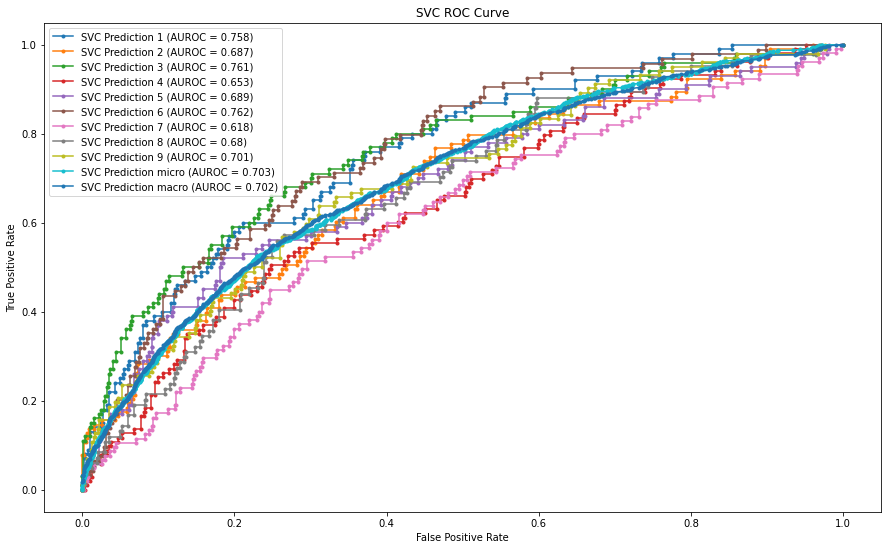

In [51]:
fig = plt.figure(figsize=(15, 9))

plot_roc_curve(fprs_svm, tprs_svm, aucs_svm, "SVC")

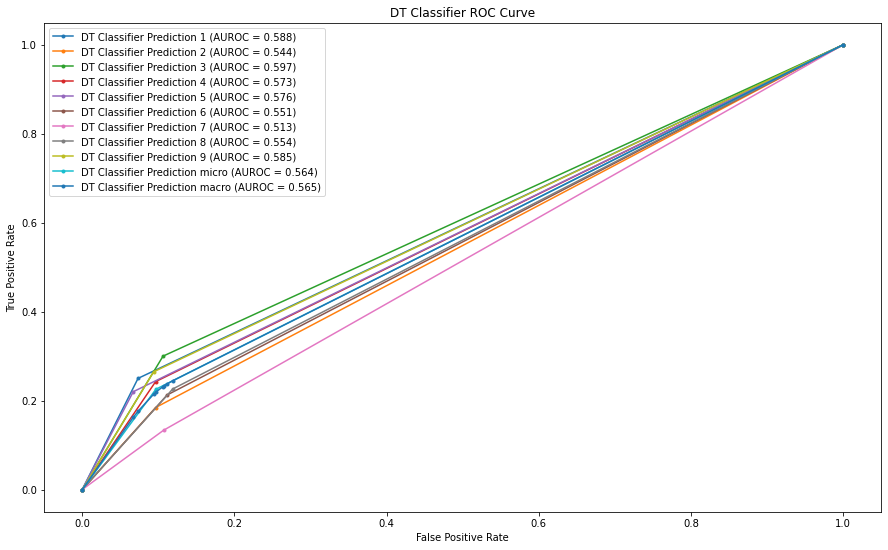

In [52]:
fig = plt.figure(figsize=(15, 9))

plot_roc_curve(fprs_dtc, tprs_dtc, aucs_dtc, "DT Classifier")

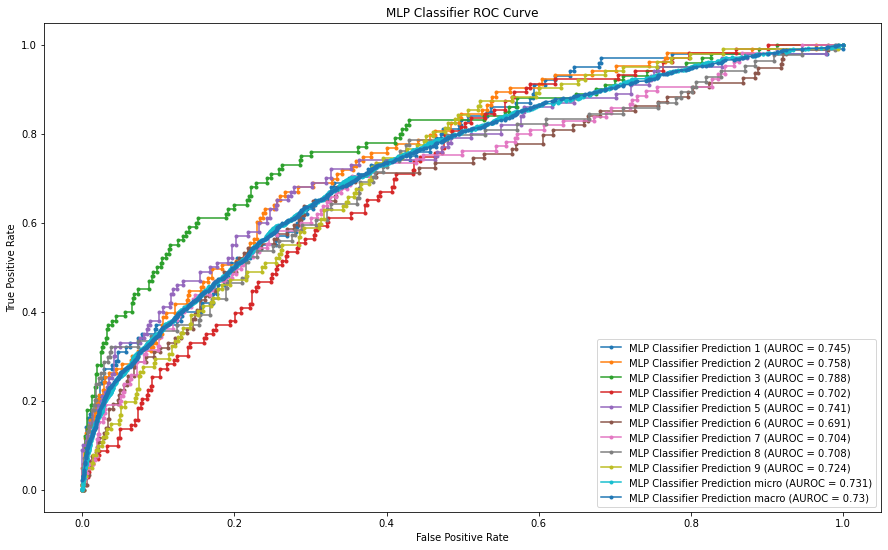

In [53]:
fig = plt.figure(figsize=(15, 9))

plot_roc_curve(fprs_mlpc, tprs_mlpc, aucs_mlpc, "MLP Classifier")

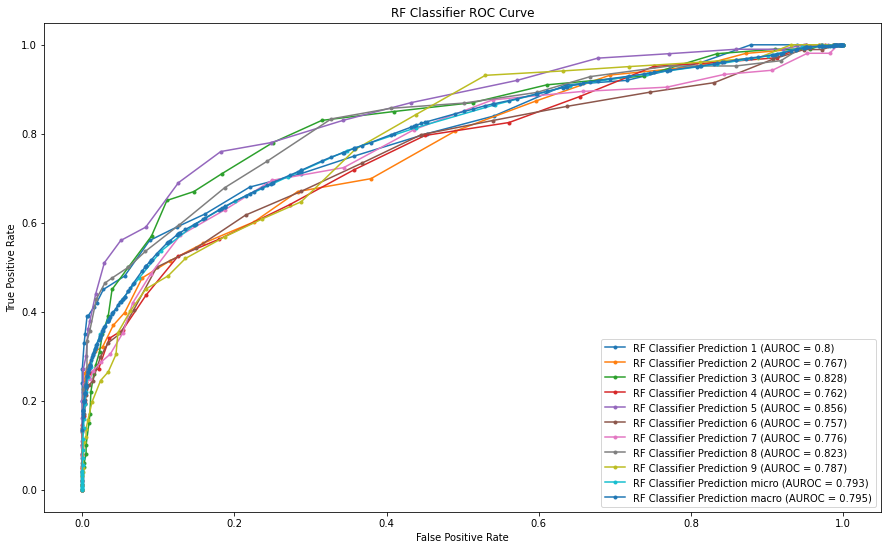

In [54]:
fig = plt.figure(figsize=(15, 9))

plot_roc_curve(fprs_rfc, tprs_rfc, aucs_rfc, "RF Classifier")

### Confusion Matrix

In [55]:
svm_pred = svm.predict(X_test)
dtc_pred = dtc.predict(X_test)
mlpc_pred = mlpc.predict(X_test)
rfc_pred = rfc.predict(X_test)

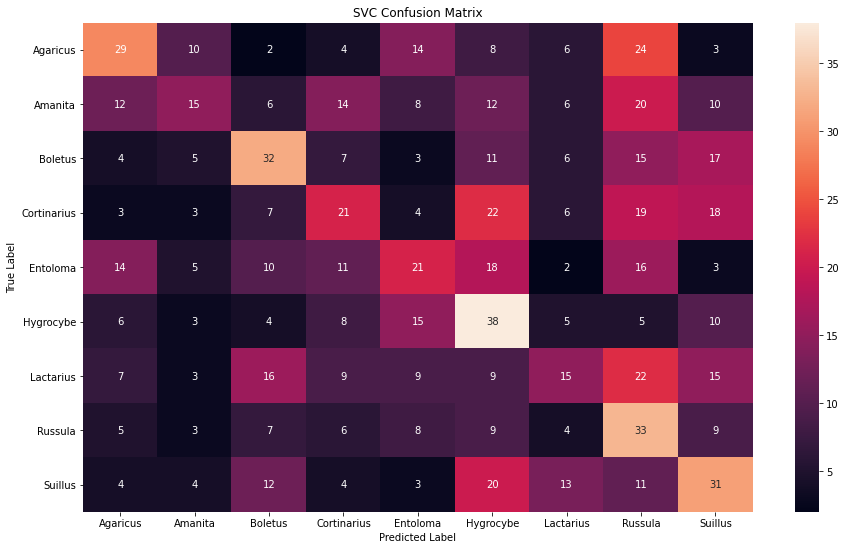

In [56]:
fig = plt.figure(figsize=(15, 9))

plot_confusion_matrix(df["Label"], y_test, svm_pred, 'SVC')

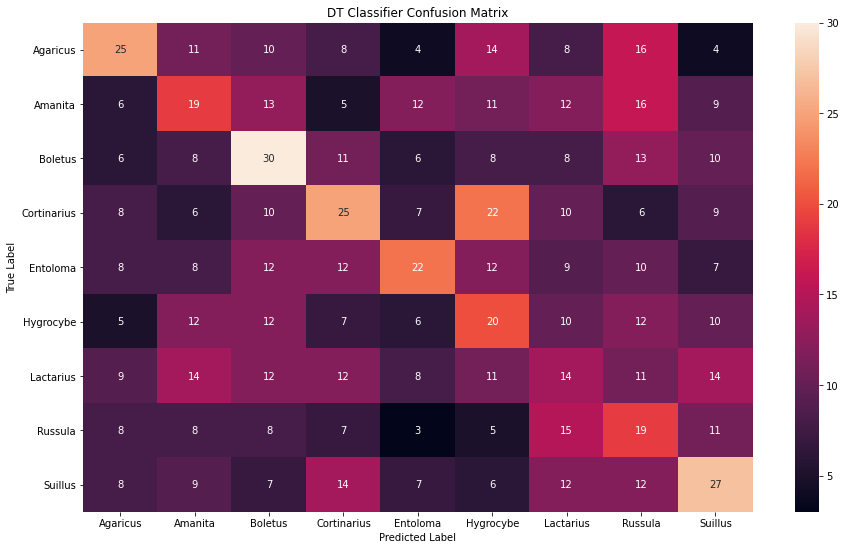

In [57]:
fig = plt.figure(figsize=(15, 9))

plot_confusion_matrix(df["Label"], y_test, dtc_pred, 'DT Classifier')

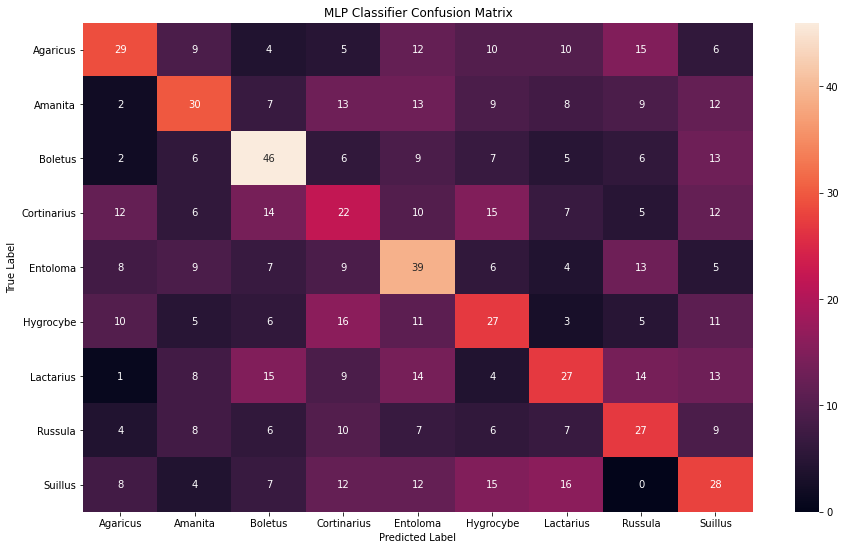

In [58]:
fig = plt.figure(figsize=(15, 9))

plot_confusion_matrix(df["Label"], y_test, mlpc_pred, 'MLP Classifier')

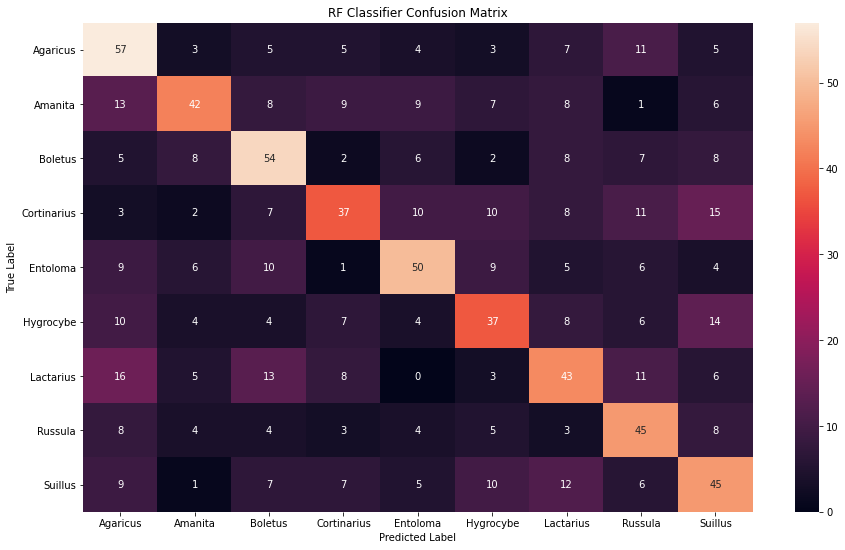

In [59]:
fig = plt.figure(figsize=(15, 9))

plot_confusion_matrix(df["Label"], y_test, rfc_pred, 'RF Classifier')